In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.special import kn
from scipy.optimize import minimize
import galkin
import galkin.processdata   # routines to process kinematic data
import galkin.readparsFile  # routines to read and check input parameters
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Constants
G = 4.302e-6#kpc/SM(km/s)^2
q_b = 0.6
r_b = 1.9#kpc
a_b = 1.#kpc
q_h = 0.8
alpha_b = 1.8
R_m = 4.#kpc
#parameters model I
rho_b_I = 0.427e9#sM/kpc^3
a_h_I = 3.83#kpc
rho_h_I = 0.711e9#SM/kpc^3
alpha_h_I = -2.
beta_h_I = 2.96
R_d_I = 2.0#kpc
R_d_II = 3.2#kpc
Sigma_d_SD_I = (1905.0e6)*0.75#SM/kpc^2
Sigma_g_ISM_I = (1905.0e6)*0.25#SM/kpc^2
#parameters model II
rho_b_II = 0.3e9#sM/kpc^3
a_h_II = 1.9#kpc
rho_h_II = 0.266e9#SM/kpc^3
alpha_h_II = 1.63
beta_h_II = 2.17
R_d_II = 3.2#kpc
Sigma_d_SD_II = (536.0e6)*0.75#SM/kpc^2
Sigma_g_ISM_II = (536.0e6)*0.25#SM/kpc^2

In [3]:
R = np.linspace(0.1,15.,100)

In [4]:
def Vc2_b(R,rho_b,q_b=q_b,alpha_b=alpha_b,r_b=r_b,a_b=a_b):
    def I_b(x,R):
        e = np.sqrt(1. - q_b**2.)
        n = x**(2.-alpha_b)*np.exp(-(R**2.*x**2.)/r_b**2.)
        d = np.sqrt(1.-x**2.*e**2.)
        t = R**2.*(R/a_b)**(-alpha_b)
        return (t*n)/d
    Rx = R.reshape(-1, 1)
    yp = np.linspace(0.,1.,100).reshape(1,-1)#integration limits
    dx = yp[0,1] - yp[0,0]
    fun = I_b(yp,Rx)
    res_int = integrate.simps(fun,dx=dx)
    return 4.*np.pi*G*q_b*rho_b*res_int

In [5]:
 def Vc2_DM(R,a_h,rho_h,alpha_h,beta_h,q_h=q_h):
    def I_h(x,R):
        e = np.sqrt(1.- q_h**2.)
        n = x**(2.-alpha_h)*(1.+ (x*R)/(a_h))**(alpha_h-beta_h)
        d = np.sqrt(1-x**2.*e**2)
        t = R**2.*(R/a_h)**(-alpha_h)
        result = (t*n)/d
        return result
    Integral_DM = []
    for i in range (0,len(R)):
        result = integrate.quad(I_h,0,1,args=(R[i]))[0]
        Integral_DM.append(result)
    return 4.*np.pi*G*q_h*rho_h*np.array(Integral_DM)

In [6]:
def Vc2_SD_simps(R,R_d,Sigma_d_SD,z=0.,alpha_0=0.5,z1=1.,z0=0.3):
    def I_SD(zp,a,R):
        d = np.sqrt((a+R)**2. + (z-zp)**2.) + np.sqrt((a-R)**2. + (z-zp)**2.)
        u = (2.*a)/d
        t2 = u/np.sqrt(1-u**2.)
        t1 = (a+R)/(np.sqrt((a+R)**2. + (z-zp)**2.)) - (a-R)/(np.sqrt((a-R)**2. + (z-zp)**2.))
        g = -a*kn(0,a/R_d)*t2*t1/d
        f = (alpha_0*np.exp(-abs(zp)/z0))/(2.*z0) + np.exp(-abs(zp)/z1)/(2.*z1) - (alpha_0*np.exp(-abs(zp)/z1))/(2.*z1)
        return R*f*g
    Integral_SD_sims = []
    a_lims = np.linspace(0.1, 15.0,len(R))
    zp_lims = np.linspace(-15.0,15.0,len(R))
    fun_zp = np.zeros(len(R))
    for k in range(0,len(R)):
        for i in range(0,len(R)):
            fun_zp[i] = integrate.simps(I_SD(zp_lims[i],a_lims,R[k]),a_lims)
        result = integrate.simps(fun_zp,zp_lims)
        Integral_SD_sims.append(result)
    return -4.*G*Sigma_d_SD*np.array(Integral_SD_sims)/R_d

In [7]:
def Vc2_ISM_simps_test(R,R_d,Sigma_g,R_m=R_m):
    def Integral_ISM_test(s,h,R):
        t1 = 1./np.sqrt(1.-s**2.)
        t2 = 1./np.sqrt(h**2. - 1.)
        t3 = np.exp(-(R*s*h)/(2.*R_d) - R_m/(R*h*s))
        t4 = (2.*R_m*R_d)/(R**2.*h**2.) - s**2.
        result = t1*t2*t3*t4
        return R**2.*result
    Integral_ISM_sims = []
    s_lims = np.linspace(0.0001,0.999,len(R))
    h_lims = np.linspace(1.001,10.0,6*len(R))
    fun_s = np.zeros(len(s_lims))
    for k in range(0,len(R)):
        for i in range(0,len(s_lims)):
            fun_s[i] = integrate.simps(Integral_ISM_test(s_lims[i],h_lims,R[k]),h_lims)
        result = integrate.simps(fun_s,s_lims)
        Integral_ISM_sims.append(result)
    return -4.*G*Sigma_g*np.array(Integral_ISM_sims)/(2.*R_d)

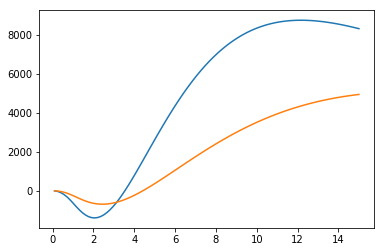

In [8]:
plt.plot(R,Vc2_ISM_simps_test(R,R_d=R_d_I,Sigma_g=Sigma_g_ISM_I,R_m=R_m))
plt.plot(R,Vc2_ISM_simps_test(R,R_d=R_d_II,Sigma_g=Sigma_g_ISM_II,R_m=R_m))

In [9]:
params_I = np.array([rho_b_I,a_h_I,rho_h_I,alpha_h_I,beta_h_I,R_d_I,Sigma_d_SD_I,Sigma_g_ISM_I])
params_II = np.array([rho_b_II,a_h_II,rho_h_II,alpha_h_II,beta_h_II,R_d_II,Sigma_d_SD_II,Sigma_g_ISM_II])

In [10]:
def Vc_tot(R,params):
    rho_b,a_h,rho_h,alpha_h,beta_h,R_d,Sigma_d_SD,Sigma_g = params
    suma = Vc2_b(R,rho_b) + Vc2_DM(R,a_h,rho_h,alpha_h,beta_h) + Vc2_SD_simps(R,R_d,Sigma_d_SD) + Vc2_ISM_simps_test(R,R_d,Sigma_g)
    return np.sqrt(suma)

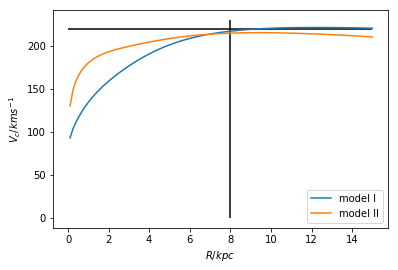

In [11]:
plt.plot(R,Vc_tot(R,params_I),label='model I')
plt.plot(R,Vc_tot(R,params_II),label='model II')
plt.hlines(220,0,15)
plt.vlines(8,0,230)
plt.xlabel(r'$R/kpc$')
plt.ylabel(r'$V_{c}/km s^{-1}$')
plt.legend(loc='lower right', prop={'size':10})

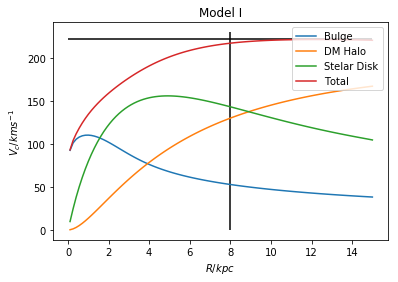

In [12]:
plt.plot(R,np.sqrt(Vc2_b(R,rho_b=rho_b_I,q_b=q_b,alpha_b=alpha_b,r_b=r_b,a_b=a_b)),label='Bulge')
plt.plot(R,np.sqrt(Vc2_DM(R,a_h=a_h_I,rho_h=rho_h_I,alpha_h=alpha_h_I,beta_h=beta_h_I,q_h=q_h)),label='DM Halo')
plt.plot(R,np.sqrt(Vc2_SD_simps(R,R_d=R_d_I,Sigma_d_SD=Sigma_d_SD_I)),label='Stelar Disk')
#plt.plot(R,np.sqrt(Vc2_ISM_simps_test(R,R_d=R_d_I,Sigma_g=Sigma_g_ISM_I)),label='Interstelar Medium')
plt.plot(R,Vc_tot(R,params_I),label='Total')
plt.xlabel(r'$R/kpc$')
plt.ylabel(r'$V_{c}/km s^{-1}$')
plt.title('Model I')
plt.hlines(222,0,15)
plt.vlines(8,0,230)
plt.legend(loc='upper right', prop={'size':10})

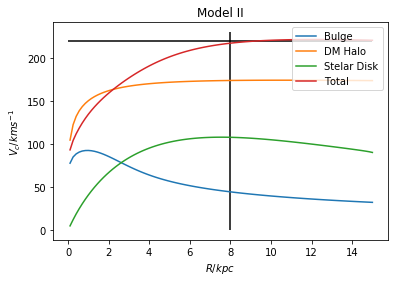

In [13]:
plt.plot(R,np.sqrt(Vc2_b(R,rho_b=rho_b_II,q_b=q_b,alpha_b=alpha_b,r_b=r_b,a_b=a_b)),label='Bulge')
plt.plot(R,np.sqrt(Vc2_DM(R,a_h=a_h_II,rho_h=rho_h_II,alpha_h=alpha_h_II,beta_h=beta_h_II,q_h=q_h)),label='DM Halo')
plt.plot(R,np.sqrt(Vc2_SD_simps(R,R_d=R_d_II,Sigma_d_SD=Sigma_d_SD_II)),label='Stelar Disk')
#plt.plot(R,np.sqrt(Vc2_ISM_simps_test(R,R_d=R_d_I,Sigma_g=Sigma_g_ISM_I)),label='Interstelar Medium')
plt.plot(R,Vc_tot(R,params_I),label='Total')
plt.xlabel(r'$R/kpc$')
plt.ylabel(r'$V_{c}/km s^{-1}$')
plt.title('Model II')
plt.hlines(220,0,15)
plt.vlines(8,0,230)
plt.legend(loc='upper right', prop={'size':10})

In [14]:
const_I=-4.*G*Sigma_g_ISM_I/(2.*R_d_I)
const_II=-4.*G*Sigma_g_ISM_II/(2.*R_d_II)

In [15]:
temp_I=Vc2_ISM_simps_test(R,R_d=R_d_I,Sigma_g=Sigma_g_ISM_I)
w=temp_I<0
temp_I[w]=0
print temp_I

[   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.           36.42730903  283.30191864
  539.73912972  803.79608184 1073.68576152 1347.77302679 1624.56877277
 1902.72290816 2181.01663231 2458.35436779 2733.75560333 3006.34682703
 3275.35367463 3540.0933762  3799.9675547  4054.45540736 4303.10728484
 4545.53867138 4781.42456105 5010.49421927 5232.52631521 5447.34440788
 5654.81276761 5854.83251383 6047.33804979 6232.29377526 6409.69105884
 6579.54545192 6741.89412747 6896.79352742 7044.31720361 7184.55383794
 7317.60542828 7443.58562796 7562.6182268  7674.83576323 7780.37825715
 7879.39205447 7972.02877438 8058.44435159 8138.79816599 8213.25225281
 8281.97058709 8345.11843643 8402.86177657 8455.36676498 8502.79926752
 8545.32443418 8583.10631964 8616.3075

In [16]:
temp_II=Vc2_ISM_simps_test(R,R_d=R_d_II,Sigma_g=Sigma_g_ISM_II)
wII=temp_II<0
temp_II[wII]=0
print temp_II

[   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.           30.57798437
  122.20382221  216.66347597  313.57252251  412.57121083  513.32348974
  615.51596338  718.8568094   823.07468523  927.91764122 1033.15205394
 1138.56158918 1243.94620097 1349.12117082 1453.91618969 1558.17448373
 1661.75198418 1764.51654091 1866.34717867 1967.1333947  2066.77449639
 2165.17897696 2262.26392783 2357.95448551 2452.18331143 2544.89010287
 2636.02113333 2725.52882052 2813.37132052 2899.51214651 2983.9198106
 3066.56748743 3147.43269811 3226.49701341 3303.74577497 3379.16783334
 3452.75530206 3524.50332648 3594.40986675 3662.47549381 3728.70319793
 3793.09820863 3855.66782573 3916.42126044 3975

In [17]:
def Vc_tot_mask_I(R,params):
    rho_b,a_h,rho_h,alpha_h,beta_h,R_d,Sigma_d_SD,Sigma_g = params
    suma = Vc2_b(R,rho_b) + Vc2_DM(R,a_h,rho_h,alpha_h,beta_h) + Vc2_SD_simps(R,R_d,Sigma_d_SD) + temp_I
    return np.sqrt(suma)

In [18]:
def Vc_tot_mask_II(R,params):
    rho_b,a_h,rho_h,alpha_h,beta_h,R_d,Sigma_d_SD,Sigma_g = params
    suma = Vc2_b(R,rho_b) + Vc2_DM(R,a_h,rho_h,alpha_h,beta_h) + Vc2_SD_simps(R,R_d,Sigma_d_SD) + temp_II
    return np.sqrt(suma)

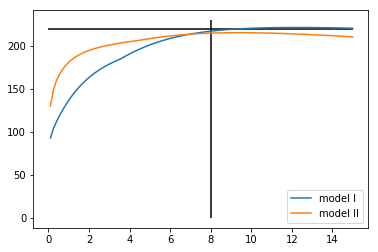

In [19]:
plt.plot(R,Vc_tot_mask_I(R,params_I),label='model I')
plt.plot(R,Vc_tot_mask_II(R,params_II),label='model II')
plt.hlines(220,0,15)
plt.vlines(8,0,230)
plt.legend(loc='lower right', prop={'size':10})

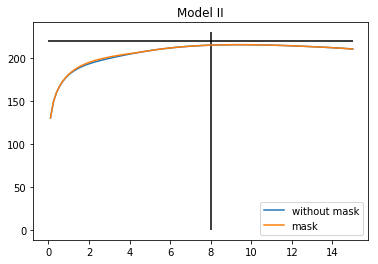

In [20]:
plt.plot(R,Vc_tot(R,params_II),label='without mask')
plt.plot(R,Vc_tot_mask_II(R,params_II),label='mask')
plt.hlines(220,0,15)
plt.vlines(8,0,230)
plt.title('Model II')
plt.legend(loc='lower right', prop={'size':10})

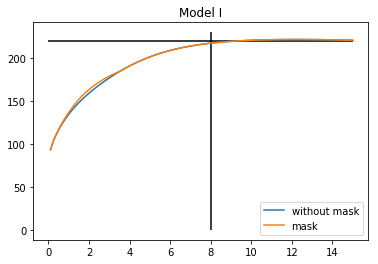

In [21]:
plt.plot(R,Vc_tot(R,params_I),label='without mask')
plt.plot(R,Vc_tot_mask_I(R,params_I),label='mask')
plt.hlines(220,0,15)
plt.vlines(8,0,230)
plt.title('Model I')
plt.legend(loc='lower right', prop={'size':10})

In [22]:
def Vc2_ISM_approx(R,R_d,Sigma_g_ISM,R_m=R_m):
    def M_g_ISM(u,R):
        return R*u*np.exp(-((R*u)/(2.*R_d))-(R_m/(R*u)))
    Integral_M_g = []
    for i in range (0,len(R)):
        result = integrate.quad(M_g_ISM,0,1,args=(R[i]))[0]
        Integral_M_g.append(result)
    return 2.*np.pi*Sigma_g_ISM*G*np.array(Integral_M_g)

In [23]:
def Vc_tot_ISMapprox(R,params):
    rho_b,a_h,rho_h,alpha_h,beta_h,R_d,Sigma_d_SD,Sigma_g_ISM = params
    suma = Vc2_b(R,rho_b) + Vc2_DM(R,a_h,rho_h,alpha_h,beta_h) + Vc2_SD_simps(R,R_d,Sigma_d_SD) + Vc2_ISM_approx(R,R_d,Sigma_g_ISM)
    return np.sqrt(suma)

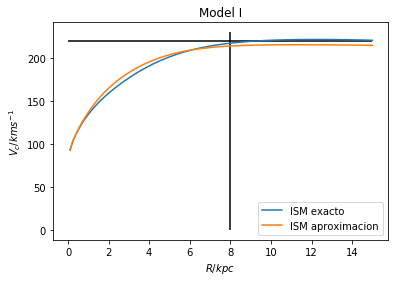

In [27]:
plt.plot(R,Vc_tot(R,params_I),label='ISM exacto')
#plt.plot(R,Vc_tot_mask_I(R,params_I),label='mask')
plt.plot(R,Vc_tot_ISMapprox(R,params_I),label='ISM aproximacion')
plt.hlines(220,0,15)
plt.vlines(8,0,230)
plt.title('Model I')
plt.legend(loc='lower right', prop={'size':10})
plt.xlabel(r'$R/kpc$')
plt.ylabel(r'$V_{c}/km s^{-1}$')
plt.savefig('Vctot_ISMapprox_exact_I.pdf')

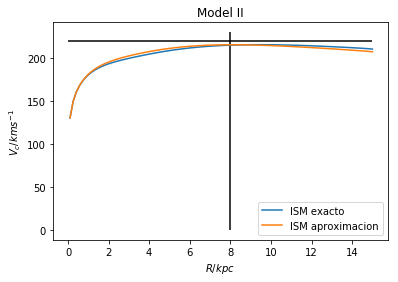

In [28]:
plt.plot(R,Vc_tot(R,params_II),label='ISM exacto')
#plt.plot(R,Vc_tot_mask_II(R,params_II),label='mask')
plt.plot(R,Vc_tot_ISMapprox(R,params_II),label='ISM aproximacion')
plt.hlines(220,0,15)
plt.vlines(8,0,230)
plt.title('Model II')
plt.legend(loc='lower right', prop={'size':10})
plt.xlabel(r'$R/kpc$')
plt.ylabel(r'$V_{c}/km s^{-1}$')
plt.savefig('Vctot_ISMapprox_exact_II.pdf')

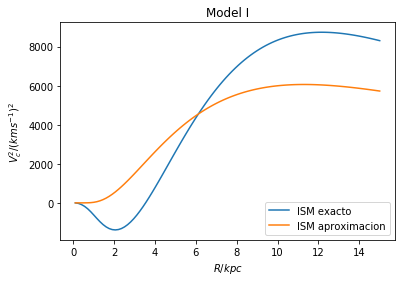

In [31]:
plt.plot(R,Vc2_ISM_simps_test(R,R_d=R_d_I,Sigma_g=Sigma_g_ISM_I,R_m=R_m),label='ISM exacto')
plt.plot(R,Vc2_ISM_approx(R,R_d=R_d_I,Sigma_g_ISM=Sigma_g_ISM_I),label='ISM aproximacion')
plt.title('Model I')
plt.legend(loc='lower right', prop={'size':10})
plt.xlabel(r'$R/kpc$')
plt.ylabel(r'$V_{c}^{2}/(km s^{-1})^{2}$')
plt.savefig('Vc2_ISMapprox_exact_I.pdf')

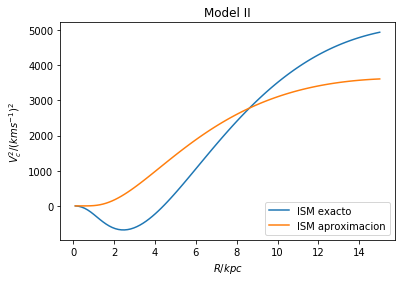

In [32]:
plt.plot(R,Vc2_ISM_simps_test(R,R_d=R_d_II,Sigma_g=Sigma_g_ISM_II,R_m=R_m),label='ISM exacto')
plt.plot(R,Vc2_ISM_approx(R,R_d=R_d_II,Sigma_g_ISM=Sigma_g_ISM_II),label='ISM aproximacion')
plt.title('Model II')
plt.legend(loc='lower right', prop={'size':10})
plt.xlabel(r'$R/kpc$')
plt.ylabel(r'$V_{c}^{2}/(km s^{-1})^{2}$')
plt.savefig('Vc2_ISMapprox_exact_II.pdf')